# Statistical analysis
This notebook performs differential expression analysis using the real template experiment and simulated experiments, as a null set. Then the set of differentially expressed genes (DEGs) obtained from this analysis are used to perform gene set enrichment analysis (GSEA) to identify pathways enriched in these set of DEGs.

*Note:* To run datatables, need to refresh the window and then run all cells (DO NOT restart and run all, only run all works).

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import seaborn as sns
import rpy2.robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#from jupyter_datatables import init_datatables_mode


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

sys.path.append("../")
from functions import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

In [3]:
# User selected experiment id
project_id = "SRP000762"
rerun_template = True
rerun_simulated = True

In [4]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
num_runs=25

In [5]:
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "Rank_pathways",
    "data",
    "metadata",
    "SRP000762_groups.tsv")

## Install R libraries

In [6]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")
#BiocManager::install('EnhancedVolcano')
#devtools::install_github('kevinblighe/EnhancedVolcano')
#BiocManager::install('clusterProfiler')
#BiocManager::install("org.Hs.eg.db")
#BiocManager::install("biomaRt")

NULL


## Differential expression analysis

In [7]:
%%R
library('limma')

### Get differentially expressed genes from template experiment

In [8]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir -i rerun_template

source('../functions/DE_analysis.R')

out_file <- paste(local_dir,
                  "DE_stats/DE_stats_template_data_",
                  project_id,
                  "_real.txt",
                  sep="")

if (rerun_template){
    get_DE_stats(metadata_file,
                 project_id, 
                 template_data_file,
                 "template",
                 local_dir,
                 "real")
    }

[1] 60


### Check signal strength

In [9]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

In [10]:
template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

template_DEGs = template_DE_stats[template_DE_stats['adj.P.Val']<0.05]
print(template_DEGs.shape)
template_DEGs.head()

(60, 6)


,logFC,AveExpr,t,P.Value,adj.P.Val,B
ENSG00000067082.14,19.385246,18.673139,14.055682,2.342010e-12,1.359233e-07,9.739709
ENSG00000177606.6,-8.236487,9.185753,-13.126898,8.859555e-12,2.570910e-07,9.292456
ENSG00000114315.3,-6.285228,6.042663,-12.840532,1.355507e-11,2.622318e-07,9.141666
ENSG00000185950.8,8.790781,17.705828,12.594113,1.966140e-11,2.852721e-07,9.006626
ENSG00000095752.6,-7.505790,7.299177,-12.204218,3.582671e-11,4.158550e-07,8.782431


In [11]:
#%%R
#library(EnhancedVolcano)

In [12]:
#%%R -i project_id -i template_DE_stats_file -i local_dir

#source('../functions/DE_analysis.R')

#create_volcano(template_DE_stats_file,
#               project_id,
#               "adj.P.Val",
#               local_dir)

### Get differentially expressed genes from each simulated experiment

In [13]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -i rerun_simulated -o num_sign_DEGs_simulated

source('../functions/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    out_file <- paste(local_dir, 
                      "DE_stats/DE_stats_simulated_data_",
                      project_id,
                      "_",
                      i,
                      ".txt", 
                      sep="")
    
    if (rerun_simulated){
        run_output <- get_DE_stats(metadata_file,
                                   project_id, 
                                   simulated_data_file,
                                   "simulated",
                                   local_dir,
                                   i)
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
    } else {
        # Read in DE stats data
        DE_stats_data <- as.data.frame(read.table(out_file, sep="\t", header=TRUE, row.names=1))
        
        # Get number of genes that exceed threshold
        threshold <- 0.05
        sign_DEGs <- DE_stats_data[DE_stats_data[,'adj.P.Val']<threshold,]
        
        num_sign_DEGs <- nrow(sign_DEGs)
        
        num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, num_sign_DEGs)
    }
}

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


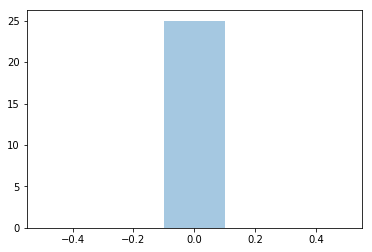

In [14]:
# Plot distribution of differentially expressed genes for simulated experiments
sns.distplot(num_sign_DEGs_simulated,
            kde=False)

**Observation:** All simulated experiments found 0 DEGs using adjusted p-value cutoff of <5%

**Check**

As a check, we compared the number of DEGs identified here versus what was reported in the [Reddy et. al. publication](https://www.ncbi.nlm.nih.gov//pubmed/19801529), which found:
* 234 genes with a significant (FDR < 5%) change in expression in response to DEX treatment. 
* After removing pseudogenes (listed in Supplemental Table S3), 209 differentially expressed genes remained 
* Of the DEX-responsive genes, more showed increases in transcript levels 123 (59%) than showed decreases 86 (41%), and the up-regulation was slightly but significantly stronger than the down-regulation

By comparison:
* Our study found 60 DEGs instead of 234. 
* Spot checking the genes identified with their list of DEX-responsive genes (Supplementary Dataset 2), we found the same genes and FC direction was consistent though magnitudes of theirs was lower compared to ours. 

## Get statistics for differential expression analysis

In [15]:
col_to_rank = 'logFC'

In [16]:
# Get ranks of template experiment
# Rank pathways by highest enrichment score
template_DE_stats['ranking'] = template_DE_stats[col_to_rank].rank(ascending = 0) 
template_DE_stats = template_DE_stats.sort_values(by=col_to_rank, ascending=False)

template_DE_stats.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking
ENSG00000264125.1,1678.911403,808.151173,1.059870,0.300891,0.531495,-4.984019,1.0
ENSG00000229276.1,1402.821520,671.971224,1.063376,0.299335,0.531357,-4.981014,2.0
ENSG00000210082.2,821.464218,10147.594571,0.547916,0.589357,0.724887,-5.323706,3.0
ENSG00000200732.1,777.003071,374.050328,1.060896,0.300435,0.531426,-4.983141,4.0
ENSG00000228253.1,775.857799,5944.350932,0.885889,0.385417,0.552448,-5.121933,5.0


In [17]:
# Concatenate simulated experiments
simulated_DE_stats_all = pd.DataFrame()
for i in range(num_runs):
    simulated_DE_stats_file = os.path.join(
        local_dir, 
        "DE_stats",
        "DE_stats_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_DE_stats = pd.read_csv(
        simulated_DE_stats_file,
        header=0,
        sep='\t',
        index_col=0)
    
    simulated_DE_stats.reset_index(inplace=True)
    
    # Add ranks of simulated experiment
    simulated_DE_stats['ranking'] = simulated_DE_stats[col_to_rank].rank(ascending = 0) 
    simulated_DE_stats = simulated_DE_stats.sort_values(by=col_to_rank, ascending=False)
    
    # Concatenate df
    simulated_DE_stats_all = pd.concat([simulated_DE_stats_all,
                                       simulated_DE_stats])
    
print(simulated_DE_stats_all.shape)
simulated_DE_stats_all.head()

(1450925, 8)


,index,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking
29841,ENSG00000281591.1,4597.867091,2199.015913,1.057327,0.302138,0.584780,-5.114569,1.0
29843,ENSG00000229276.1,3835.325295,1834.311261,1.057327,0.302138,0.584780,-5.114569,2.0
28254,ENSG00000075624.13,2234.895167,2431.335739,1.144976,0.264848,0.544002,-5.032193,3.0
29866,ENSG00000276007.1,1279.786894,612.100826,1.057324,0.302139,0.584780,-5.114572,4.0
29845,ENSG00000276980.1,1130.097432,540.498130,1.057327,0.302138,0.584780,-5.114569,5.0


In [18]:
simulated_DE_summary_stats = simulated_DE_stats_all.groupby(['index'])[[col_to_rank, 'adj.P.Val', 'ranking']].agg({
    col_to_rank:['mean', 'std','count'],
    'adj.P.Val':['median'],
    'ranking':['median']
})

simulated_DE_summary_stats.head()

logFC                 adj.P.Val  ranking
                        mean       std count    median   median
index                                                          
ENSG00000000003.14  0.216765  0.303148    25  0.879047   8904.0
ENSG00000000005.5   0.001933  0.006770    25  0.977763  19576.5
ENSG00000000419.12  2.241911  1.478394    25  0.725082   1609.0
ENSG00000000457.13  0.216039  0.115236    25  0.681224   6998.0
ENSG00000000460.16  0.123367  0.169765    25  0.924282   9519.0

In [19]:
# Merge template statistics with simulated statistics
template_simulated_DE_stats = template_DE_stats.merge(simulated_DE_summary_stats, 
                                                     left_index=True,
                                                     right_index=True)
print(template_simulated_DE_stats.shape)
template_simulated_DE_stats.head()

(58037, 12)


/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,logFC,AveExpr,t,P.Value,adj.P.Val,B,ranking,"(logFC, mean)","(logFC, std)","(logFC, count)","(adj.P.Val, median)","(ranking, median)"
ENSG00000264125.1,1678.911403,808.151173,1.059870,0.300891,0.531495,-4.984019,1.0,50.264600,80.288095,25,0.584247,475.0
ENSG00000229276.1,1402.821520,671.971224,1.063376,0.299335,0.531357,-4.981014,2.0,1024.128898,1290.523085,25,0.580464,5.0
ENSG00000210082.2,821.464218,10147.594571,0.547916,0.589357,0.724887,-5.323706,3.0,53.927394,661.780706,25,0.971493,58000.0
ENSG00000200732.1,777.003071,374.050328,1.060896,0.300435,0.531426,-4.983141,4.0,26.514304,41.965338,25,0.584247,571.0
ENSG00000228253.1,775.857799,5944.350932,0.885889,0.385417,0.552448,-5.121933,5.0,95.819618,265.108963,25,0.963800,92.0


In [20]:
# Parse columns
median_pval_simulated = template_simulated_DE_stats[('adj.P.Val','median')]
median_rank_simulated = template_simulated_DE_stats[('ranking','median')]
mean_test_simulated = template_simulated_DE_stats[(col_to_rank,'mean')]
std_test_simulated = template_simulated_DE_stats[(col_to_rank,'std')]
count_simulated = template_simulated_DE_stats[(col_to_rank,'count')]

In [22]:
summary = pd.DataFrame(data={'Gene ID': template_simulated_DE_stats.index,
                             'Adj P-value (Real)': template_simulated_DE_stats['adj.P.Val'],
                             'Rank (Real)': template_simulated_DE_stats['ranking'],
                             'Test statistic (Real)': template_simulated_DE_stats[col_to_rank],
                             'Median adj p-value (simulated)': median_pval_simulated ,
                             'Median rank (simulated)': median_rank_simulated ,
                             'Mean test statistic (simulated)': mean_test_simulated ,
                             'Std deviation (simulated)': std_test_simulated,
                             'Number of experiments (simulated)': count_simulated
                            }
                      )
summary['Z score'] = (summary['Test statistic (Real)'] - summary['Mean test statistic (simulated)'])/summary['Std deviation (simulated)']
summary.head()

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
ENSG00000264125.1,ENSG00000264125.1,0.531495,1.0,1678.911403,0.584247,475.0,50.264600,80.288095,25,20.285035
ENSG00000229276.1,ENSG00000229276.1,0.531357,2.0,1402.821520,0.580464,5.0,1024.128898,1290.523085,25,0.293441
ENSG00000210082.2,ENSG00000210082.2,0.724887,3.0,821.464218,0.971493,58000.0,53.927394,661.780706,25,1.159805
ENSG00000200732.1,ENSG00000200732.1,0.531426,4.0,777.003071,0.584247,571.0,26.514304,41.965338,25,17.883539
ENSG00000228253.1,ENSG00000228253.1,0.552448,5.0,775.857799,0.963800,92.0,95.819618,265.108963,25,2.565127


In [23]:
summary.sort_values(by="Z score", ascending=False)

,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
ENSG00000231053.1,ENSG00000231053.1,0.515574,48376.0,-1.809574,0.469077,54630.0,-3.117008,0.000725,25,1803.750894
ENSG00000207135.1,ENSG00000207135.1,0.532513,38434.0,-1.016753,0.469077,50595.0,-2.033245,0.000600,25,1693.138607
ENSG00000277828.1,ENSG00000277828.1,0.532513,7689.0,0.187870,1.000000,16387.0,-0.000034,0.000117,25,1601.296648
ENSG00000238124.1,ENSG00000238124.1,0.532513,28946.5,-0.589662,0.469077,44267.0,-1.179318,0.000373,25,1579.645423
ENSG00000225911.1,ENSG00000225911.1,0.532513,25548.0,-0.469049,0.469077,42634.0,-1.009997,0.000387,25,1396.811969
ENSG00000232529.1,ENSG00000232529.1,0.490147,27694.0,-0.545429,0.469077,40352.0,-0.785548,0.000183,25,1311.243896
ENSG00000270829.1,ENSG00000270829.1,0.490147,54432.0,-3.032371,0.469077,55470.0,-3.546424,0.000393,25,1306.920278
ENSG00000266416.1,ENSG00000266416.1,0.531357,3326.0,1.672872,1.000000,16387.0,-0.000522,0.001313,25,1274.033372
ENSG00000200444.1,ENSG00000200444.1,0.490147,3456.0,1.564541,1.000000,17680.0,-0.000042,0.001248,25,1253.896058
ENSG00000256717.1,ENSG00000256717.1,0.556127,16746.0,-0.174638,0.469077,36018.0,-0.379028,0.000167,25,1225.788027


In [24]:
# Save file
summary_file = os.path.join(
        local_dir, 
        "gene_summary_table.tsv")

summary.to_csv(summary_file, float_format='%.5f', sep='\t')

## Gene set enrichment analysis

**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

**Note:** Since there were 0 differentially expressed genes using simulated experiments, we used gene set enrichement analysis instead of over-representation analysis to get ranking of genes

In [25]:
# Load Hallmark pathways database used by Powers et. al.
# https://github.com/CostelloLab/GSEA-InContext/blob/master/data/gene_sets/hallmarks.gmt
hallmark_DB_file = os.path.join(
    local_dir,
    "hallmark_DB.gmt")

In [26]:
%%R
suppressWarnings(library("clusterProfiler"))
suppressWarnings(library("org.Hs.eg.db"))
suppressWarnings(library("DOSE"))
suppressWarnings(library("biomaRt"))

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/py

### Get pathway enrichment for template experiment

In [27]:
%%R -i template_DE_stats_file -o gene_id_mapping

source('../functions/GSEA_analysis.R')

gene_id_mapping <- get_ensembl_symbol_mapping(template_DE_stats_file)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Cache found

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [28]:
# Set ensembl id as index
gene_id_mapping.set_index("ensembl_gene_id", inplace=True)
print(gene_id_mapping.shape)
gene_id_mapping.head()

(57210, 1)


,hgnc_symbol
ensembl_gene_id,
ENSG00000002330,BAD
ENSG00000003137,CYP26B1
ENSG00000003249,DBNDD1
ENSG00000004799,PDK4
ENSG00000006062,MAP3K14


In [29]:
# Replace ensembl ids with gene symbols
utils.replace_ensembl_ids(template_DE_stats_file,
                          gene_id_mapping)

In [30]:
%%R -i template_DE_stats_file -i hallmark_DB_file -o template_enriched_pathways

source('../functions/GSEA_analysis.R')

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_file, hallmark_DB_file)

In [31]:
print(template_enriched_pathways.shape)
template_enriched_pathways.head()

(20, 11)


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment
0,HALLMARK_ADIPOGENESIS,HALLMARK_ADIPOGENESIS,189,0.449242,1.376190,0.000999,0.004163,0.002366,13232,"tags=47%, list=34%, signal=31%",AK2/UQCR10/CCNG2/ECHS1/MDH2/CD151/ANGPT1/TALDO...
1,HALLMARK_DNA_REPAIR,HALLMARK_DNA_REPAIR,141,0.477451,1.443748,0.000999,0.004163,0.002366,10751,"tags=43%, list=28%, signal=31%",SUPT4H1/UMPS/POLR3C/RFC5/SEC61A1/DGUOK/IMPDH2/...
2,HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,194,0.542046,1.663152,0.000999,0.004163,0.002366,12057,"tags=62%, list=31%, signal=43%",AK2/TUBB/SRSF2/MCM2/RPA1/LYAR/SLBP/DCK/KIF2C/H...
3,HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,190,0.523181,1.602536,0.000999,0.004163,0.002366,13134,"tags=62%, list=34%, signal=41%",BUB3/PRMT5/SRSF2/CUL4A/MCM2/MNAT1/UCK2/CUL1/SM...
4,HALLMARK_MITOTIC_SPINDLE,HALLMARK_MITOTIC_SPINDLE,197,0.466652,1.431851,0.000999,0.004163,0.002366,12750,"tags=48%, list=33%, signal=32%",DYNLL2/ARHGEF7/UXT/PLEKHG2/SPTAN1/KIF15/APC/KI...


### Get pathway enrichment for simulated experiments

In [32]:
# Replace ensembl ids with gene symbols
if rerun_simulated:
    for i in range(num_runs):
        simulated_DE_stats_file = os.path.join(
            local_dir, 
            "DE_stats",
            "DE_stats_simulated_data_"+project_id+"_"+str(i)+".txt")

        utils.replace_ensembl_ids(simulated_DE_stats_file,
                                  gene_id_mapping)

In [33]:
%%R -i project_id -i local_dir -i hallmark_DB_file -i num_runs -i rerun_simulated

source('../functions/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    out_file = paste(local_dir, 
                     "GSEA_stats/GSEA_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep="")
    
    if (rerun_simulated){
        enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file, hallmark_DB_file) 
    
        write.table(enriched_pathways, file = out_file, row.names = T, sep = "\t", quote = F)
        }
    }

**Check**

Again, we want to compare our ranked pathways found against what was reported in the original publication.

*The DEX-responsive genes that we identified are primarily implicated in two broad classes: stress response and development (Table 1; Reimand et al. 2007). Comparison to Gene Ontology (GO) categories (Ashburner et al. 2000) revealed that the identified genes are involved in stress response (P = 6 × 10−11), organ development (P = 5 × 10−15), cell differentiation (P = 1 × 10−11), hormone secretion (P = 4 × 10−7), and apoptosis (P = 5 × 10−12).*

We found pathways that are consistent with what publication found: pathways related to anatomical structure (i.e. vinculin, ) and cell differentiation (i.e. centromeric sister chromatid cohesion), hormone secretion (i.e. somatic hypermutation of immunoglobulin genes)

## Get statistics for enriched pathways
Examine the enriched pathways identified from template experiment -- How are these enriched pathways ranked in the simulated experiments?

### Template experiment

In [34]:
col_to_rank = 'enrichmentScore'

In [35]:
# Get ranks of template experiment
# Rank pathways by highest enrichment score
template_enriched_pathways['ranking'] = template_enriched_pathways[col_to_rank].rank(ascending = 0) 
template_enriched_pathways = template_enriched_pathways.sort_values(by=col_to_rank, ascending=False)

# Set index to GO ID
template_enriched_pathways.set_index("ID", inplace=True)
print(template_enriched_pathways.shape)
template_enriched_pathways.head()

(20, 11)


,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ranking
ID,,,,,,,,,,,
HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,106,0.572412,1.706215,0.000999,0.004163,0.002366,9573,"tags=52%, list=25%, signal=39%",NFYA/NFYB/ALDH18A1/ATF4/NOP14/NHP2/CNOT2/PARN/...,1.0
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,193,0.548231,1.681245,0.000999,0.004163,0.002366,12807,"tags=71%, list=33%, signal=48%",PSMC4/BUB3/PWP1/SRSF2/APEX1/RPS2/MCM2/SRSF7/NH...,2.0
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,46,0.542762,1.541286,0.000999,0.004163,0.002366,11423,"tags=52%, list=29%, signal=37%",FTL/G6PD/NDUFS2/ABCC1/SRXN1/NDUFA6/NQO1/PFKP/I...,3.0
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,194,0.542046,1.663152,0.000999,0.004163,0.002366,12057,"tags=62%, list=31%, signal=43%",AK2/TUBB/SRSF2/MCM2/RPA1/LYAR/SLBP/DCK/KIF2C/H...,4.0
HALLMARK_PROTEIN_SECRETION,HALLMARK_PROTEIN_SECRETION,95,0.526593,1.561999,0.000999,0.004163,0.002366,12685,"tags=62%, list=33%, signal=42%",VAMP7/GNAS/AP2M1/MAPK1/STAM/AP2S1/SGMS1/CAV2/S...,5.0


In [36]:
# Check that GO IDs are unique
template_enriched_pathways.index.nunique() == len(template_enriched_pathways)

True

### Simulated experiments 

In [37]:
# Concatenate simulated experiments
simulated_enriched_pathways_all = pd.DataFrame()
for i in range(num_runs):
    simulated_GSEA_file = os.path.join(
        local_dir, 
        "GSEA_stats",
        "GSEA_simulated_data_"+project_id+"_"+str(i)+".txt")
    
    #Read results
    simulated_enriched_pathways = pd.read_csv(
        simulated_GSEA_file,
        header=0,
        sep='\t',
        index_col=0)
    
    # Add ranks of simulated experiment
    simulated_enriched_pathways['ranking'] = simulated_enriched_pathways[col_to_rank].rank(ascending = 0) 
    simulated_enriched_pathways = simulated_enriched_pathways.sort_values(by=col_to_rank, ascending=False)
    
    # Concatenate df
    simulated_enriched_pathways_all = pd.concat([simulated_enriched_pathways_all,
                                       simulated_enriched_pathways])
    
print(simulated_enriched_pathways_all.shape)
simulated_enriched_pathways_all.head()

(857, 12)


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ranking
HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V1,193,0.556160,1.724459,0.000999,0.002498,0.000263,14297,"tags=85%, list=37%, signal=54%",PPM1G/BUB3/TCP1/RPL22/RPS2/PSMA1/SNRPA1/TFDP1/...,1.0
HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,HALLMARK_E2F_TARGETS,194,0.524376,1.626481,0.000999,0.002498,0.000263,13584,"tags=75%, list=35%, signal=49%",AURKA/RACGAP1/CDKN1A/CDKN3/ATAD2/TIPIN/PPM1D/T...,2.0
HALLMARK_MYC_TARGETS_V2,HALLMARK_MYC_TARGETS_V2,HALLMARK_MYC_TARGETS_V2,58,0.517846,1.512182,0.000999,0.002498,0.000263,13264,"tags=71%, list=34%, signal=47%",SLC19A1/NIP7/MRTO4/LAS1L/HSPE1/WDR74/MYBBP1A/M...,3.0
HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY,46,0.516290,1.482771,0.002000,0.003125,0.000329,16437,"tags=85%, list=42%, signal=49%",PRDX1/SBNO2/JUNB/MBP/CDKN2D/GPX3/ABCC1/SOD1/PR...,4.0
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,190,0.506406,1.570335,0.000999,0.002498,0.000263,15491,"tags=77%, list=40%, signal=47%",AURKA/ODF2/RACGAP1/NCL/BUB3/CDKN3/E2F1/TNPO2/S...,5.0


In [38]:
simulated_enriched_pathways_stats = simulated_enriched_pathways_all.groupby(['ID'])[['enrichmentScore', 'pvalue', 'ranking']].agg({
    col_to_rank:['mean', 'std','count'],
    'pvalue':['median'],
    'ranking':['median']
})

simulated_enriched_pathways_stats.head()

enrichmentScore                    pvalue ranking
                                        mean       std count    median  median
ID                                                                            
HALLMARK_ADIPOGENESIS               0.442502  0.026254    25  0.000999    16.0
HALLMARK_ALLOGRAFT_REJECTION        0.424805  0.035230    19  0.000999    27.0
HALLMARK_ANDROGEN_RESPONSE          0.452496  0.025508    18  0.002498    17.0
HALLMARK_ANGIOGENESIS               0.512233  0.019648     5  0.012987     6.0
HALLMARK_APICAL_JUNCTION            0.425509  0.028067    20  0.000999    25.5

In [39]:
# Merge template statistics with simulated statistics
template_simulated_enriched_pathways_stats = template_enriched_pathways.merge(simulated_enriched_pathways_stats, 
                                                                              how='outer',
                                                                              left_index=True,
                                                                              right_index=True)
template_simulated_enriched_pathways_stats.head()

,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalues,rank,leading_edge,core_enrichment,ranking,"(enrichmentScore, mean)","(enrichmentScore, std)","(enrichmentScore, count)","(pvalue, median)","(ranking, median)"
ID,,,,,,,,,,,,,,,,
HALLMARK_ADIPOGENESIS,HALLMARK_ADIPOGENESIS,189.0,0.449242,1.376190,0.000999,0.004163,0.002366,13232.0,"tags=47%, list=34%, signal=31%",AK2/UQCR10/CCNG2/ECHS1/MDH2/CD151/ANGPT1/TALDO...,14.0,0.442502,0.026254,25,0.000999,16.0
HALLMARK_ALLOGRAFT_REJECTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424805,0.035230,19,0.000999,27.0
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,96.0,0.444627,1.319452,0.009990,0.029382,0.016702,12826.0,"tags=46%, list=33%, signal=31%",UAP1/UBE2J1/HERC3/RAB4A/GNAI3/ELK4/TPD52/APPBP...,15.0,0.452496,0.025508,18,0.002498,17.0
HALLMARK_ANGIOGENESIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512233,0.019648,5,0.012987,6.0
HALLMARK_APICAL_JUNCTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.425509,0.028067,20,0.000999,25.5


In [40]:
# Parse columns
median_pval_simulated = template_simulated_enriched_pathways_stats[('pvalue','median')]
median_rank_simulated = template_simulated_enriched_pathways_stats[('ranking','median')]
mean_test_simulated = template_simulated_enriched_pathways_stats[(col_to_rank,'mean')]
std_test_simulated = template_simulated_enriched_pathways_stats[(col_to_rank,'std')]
count_simulated = template_simulated_enriched_pathways_stats[(col_to_rank,'count')]

### Calculations for summary table

In [41]:
#init_datatables_mode()

In [42]:
summary = pd.DataFrame(data={'Pathway': template_simulated_enriched_pathways_stats.index,
                             'P-value (Real)': template_simulated_enriched_pathways_stats['pvalue'],
                             'Rank (Real)': template_simulated_enriched_pathways_stats['ranking'],
                             'Test statistic (Real)': template_enriched_pathways[col_to_rank],
                             'Median p-value (simulated)': median_pval_simulated ,
                             'Median rank (simulated)': median_rank_simulated ,
                             'Mean test statistic (simulated)': mean_test_simulated ,
                             'Std deviation (simulated)': std_test_simulated,
                             'Number of experiments (simulated)': count_simulated
                            }
                      )
summary['Z score'] = (summary['Test statistic (Real)'] - summary['Mean test statistic (simulated)'])/summary['Std deviation (simulated)']
summary

,Pathway,P-value (Real),Rank (Real),Test statistic (Real),Median p-value (simulated),Median rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
HALLMARK_ADIPOGENESIS,HALLMARK_ADIPOGENESIS,0.000999,14.0,0.449242,0.000999,16.0,0.442502,0.026254,25,0.256710
HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ALLOGRAFT_REJECTION,NaN,NaN,NaN,0.000999,27.0,0.424805,0.035230,19,NaN
HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE,0.009990,15.0,0.444627,0.002498,17.0,0.452496,0.025508,18,-0.308466
HALLMARK_ANGIOGENESIS,HALLMARK_ANGIOGENESIS,NaN,NaN,NaN,0.012987,6.0,0.512233,0.019648,5,NaN
HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_JUNCTION,NaN,NaN,NaN,0.000999,25.5,0.425509,0.028067,20,NaN
HALLMARK_APICAL_SURFACE,HALLMARK_APICAL_SURFACE,NaN,NaN,NaN,0.034466,19.0,0.471780,0.022846,2,NaN
HALLMARK_APOPTOSIS,HALLMARK_APOPTOSIS,0.012987,18.0,0.419026,0.001998,19.0,0.434619,0.032389,21,-0.481440
HALLMARK_BILE_ACID_METABOLISM,HALLMARK_BILE_ACID_METABOLISM,NaN,NaN,NaN,0.011489,31.0,0.408767,0.013336,10,NaN
HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_CHOLESTEROL_HOMEOSTASIS,NaN,NaN,NaN,0.004995,13.0,0.458548,0.026444,21,NaN
HALLMARK_COAGULATION,HALLMARK_COAGULATION,NaN,NaN,NaN,0.000999,5.0,0.474545,0.049298,22,NaN


In [43]:
# Save file
summary_file = os.path.join(
        local_dir, 
        "pathway_summary_table.tsv")

summary.to_csv(summary_file, float_format='%.5f', sep='\t')

There are a few immune pathways that are template-enriched but there are others that look to be involved in cellular maintenancem, which I wouldn't expect to be specific to these experiment.

For GSEA I am currently using the p-values from the DE analysis to rank genes, should I try using avg gene expression instead..? Maybe p-values don't cluster genes as much..?

Note: this notebook takes ~1hr to run

**Check:**
* Are there template-specific pathways (i.e. pathways specific to Dexamethasone treatment) that we can use as a positive?
* Are there agnostic pathways that we can use as a negative control?